In [1]:
# #!/bin/sh

# cd ~
# touch .netrc
# echo "machine urs.earthdata.nasa.gov login wangshujian password wsj821100" > .netrc
# chmod 0600 .netrc

# cd ~
# touch .urs_cookies

# wget -P /mnt/d/Desktop/download --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -i /mnt/d/Desktop/sichuan1.txt 


In [1]:
import requests

doi = '10.3334/ORNLDAAC/1907'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

C2107797704-ORNL_DAAC


In [5]:
import datetime as dt 

# Brazil bounding box
bound = (73.4466, 6.318,135.0859, 53.5580) 

# time bound
start_date = dt.datetime(2020, 8, 1) # specify your own start date
end_date = dt.datetime(2020, 9, 1)  # specify your end start date

In [6]:
import pandas as pd
from shapely.geometry import MultiPolygon, Polygon, box

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
    # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str
    }
    
    granulesearch = cmrurl + 'granules.json'

    response = requests.get(granulesearch, params=cmr_param)
    granules = response.json()['feed']['entry']
    
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
            
            # read file size
            granule_size = float(g['granule_size'])
            
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break

# adding bound as the last row into the dataframe
# we will use this later in the plot
b = list(bound)
granule_arr.append(['bound', 0, box(b[0], b[1], b[2], b[3])]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1)
print ("Total file size (MB): ", l4adf['granule_size'].sum())

Total granules found:  270
Total file size (MB):  218118.496575


(6.068, 53.808)

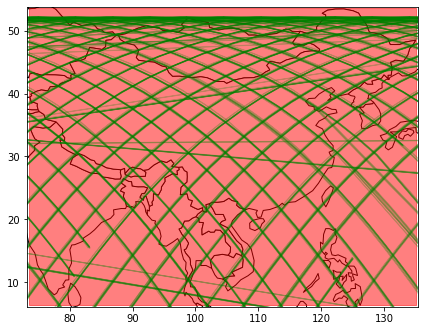

In [7]:
import geopandas
gdf = geopandas.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='red', edgecolor='red', alpha=0.5)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.2)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-0.25, maxx+0.25)
ax.set_ylim(miny-0.25, maxy+0.25)

In [6]:
l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('D:\Desktop\china\china_bound.txt', columns = ['granule_url'], index=False, header = False)